# Importation biblioteques

In [17]:
import codecs
import re
import os.path
import string
import unicodedata

import numpy as np
import matplotlib.pyplot as plt

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import warnings

warnings.filterwarnings("ignore")

# Fonction

In [18]:
def load_pres(fname):
    alltxts = []
    alllabs = []

    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return alltxts,alllabs


def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs


def top_n_mot(vectorizer,data,n=100):
    X = vectorizer.fit_transform(data)
    vocabulaire = vectorizer.get_feature_names()   
    occurrences = X.sum(axis=0).T
    
    counter = Counter( { vocabulaire[i] : occurrences[i] for i in range(len(vocabulaire)) } )
    tuple_mot_occur  = counter.most_common(n)
    mot = []
#     occur = []
    for i,j in tuple_mot_occur :
        mot.append(i)
#         occur.append(j)
        
    return mot

def affiche_word_cloud_top_100(vectorizer,data,title,n=100):
    mot = top_n_mot(vectorizer,data,n=n)
    words = " ".join(mot)
    wordcloud = WordCloud(background_color='white', max_words=100).generate(words)
    plt.imshow(wordcloud)
    plt.title(title,fontsize=15)
    
def odd_ratio(vectorizer,data):
    X1 = vectorizer[1].fit_transform(data[1])
    vocab_1 = vectorizer[1].get_feature_names()
    occ_1 = X1.sum(axis=0).T

    X2 = vectorizer[2].fit_transform(data[2])
    vocab_2 = vectorizer[2].get_feature_names()
    occ_2 = X2.sum(axis=0).T

    # Vocabulaire global
    vocab = set(vocab_1).union(vocab_2)        
    # Calcul des tf de la 1ère classe

    tf_1 = { vocab_1[i] : occ_1[i].A[0][0] for i in range(len(vocab_1)) }
    total_1 = sum(tf_1.values())
    p = { word: tf_1.get(word, 0) / total_1 for word in vocab }

    # Calcul des tf de la 2e classe
    tf_2 = { vocab_2[i] : occ_2[i].A[0][0] for i in range(len(vocab_2)) }
    total_2 = sum(tf_2.values())
    q = { word: tf_2.get(word, 0) / total_2 for word in vocab }

    # Calcul des odds ratio
    odds_ratio = { word : ( p[word] * (1 - q[word]) + 0.1 ) / ( q[word] * (1 - p[word]) + 0.1 ) for word in vocab }
    return odds_ratio


def affichage_odd_ratio(vectorizer,data,title,n=100):
    #calcule_odd_ratio
    odds_ratio = odd_ratio(vectorizer,data)


    # Affiche pour tous le monde
    mot = []
    occur = []
    for i,j in odds_ratio.items() :
        mot.append(i)
        occur.append(j)


    ind = 1
    plt.figure()
    ind =  np.argsort(np.array(occur))[:100:-1]
    words = " ".join(np.array(mot)[ind])
    wordcloud = WordCloud(background_color='white', max_words=100).generate(words)
    plt.imshow(wordcloud)
    plt.title(title[0],fontsize=15)

    ##############################################################
    #Affiche classe 1
    
    label = -1
    reverse = True if label == -1 else False
    sorted_ratios = dict( sorted( odds_ratio.items(), key=lambda item: item[1], reverse=reverse))
    ratios_dict = { word : sorted_ratios[word] if reverse==True else 1/sorted_ratios[word]  for word in list(sorted_ratios.keys())[:n] }

    stopwords_ = set(stopwords.words("french"))

    wc = WordCloud(background_color="white", max_words=n,
                    collocations=False, stopwords=stopwords.words("french"))
    wc.generate_from_frequencies(ratios_dict)

    # Affichage
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title[1],fontsize=15)
    plt.show()

    ##############################################################
    #Affiche classe -1
    
    label = 1
    reverse = True if label == -1 else False
    sorted_ratios = dict( sorted( odds_ratio.items(), key=lambda item: item[1], reverse=reverse))
    ratios_dict = { word : sorted_ratios[word] if reverse==True else 1/sorted_ratios[word]  for word in list(sorted_ratios.keys())[:n] }

    stopwords_ = set(stopwords.words("french"))

    wc = WordCloud(background_color="white", max_words=n,
                    collocations=False, stopwords=stopwords.words("french"))
    wc.generate_from_frequencies(ratios_dict)  
    # Affichage
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title[2],fontsize=15)
    plt.show()


def affiche_zipf(alltxts) :
    words = "".join(flatten(alltxts))
    unique_words, count = np.unique(words.split(), return_counts=True)
    count = np.log(count+1)

    count_sort_ind = np.argsort(count)
    unique_words = unique_words[count_sort_ind]
    count = np.sort(count)
    print(count)
    print(unique_words)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_axes([0,0,1,1])
    ax.bar(np.arange(len(count)),count)
    plt.title("Log du nombre d'apparition / mot")
    plt.show()

def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): 
            rt.extend(flatten(i))
        else: 
            rt.append(i)
    return rt

import pandas as pd

def result_for_pandas(vectorizer,clf,X_train,X_test,Y_train,Y_test,windows=10,threshold=0.5):
#def result_for_pandas(vectorizer,final,X_train_final,X_test_final,Y_train_final,Y_test_final):
    #X_final_vector = vectorizer.fit_transform(X_train_final)
    #X_test_vector = vectorizer.transform(X_test_final)
    #final.fit(X_final_vector,  Y_train_final)
    #grid_predictions = final.predict(X_test_vector)
    
    X_train_2 = vectorizer.fit_transform(X_train,y_train)
    X_test_2 = vectorizer.transform(X_test)

    #clf = sv.LinearSVC(C=100, class_weight="balanced")
    X_train_3 = clf.fit(X_train_2,y_train)
    y_pred = clf.predict(X_test_2)
    #y_pred = final_postprocessing(y_pred, windows, threshold)
    #classification_report(y_test,y_pred)
    #return classification_report(Y_test_final, grid_predictions,output_dict=True),X_final_vector
    return classification_report(y_test, y_pred,output_dict=True),X_train_2


def result_for_graphic_min_max_df(liste_x,liste_y,final,X_train_final,X_test_final,Y_train_final,Y_test_final,dico_param,windows=10,threshold=0.5):
    result = []
    f1_score_0 = 0.;f1_score_1=0.;recall_0= 0.;recall_1= 0.;precision_0= 0.;precision_1= 0.;nb_mot= 0.
    
    for i in liste_x:
        temps = []
        for j in liste_y:
#             try :
            vectorizer_exp = TfidfVectorizer(
#                     lowercase=dico_param["lowercase"],
#                      stop_words=dico_param["stop_words"],
#                      strip_accents=dico_param["strip_accents"],
#                      # use_idf=dico_param["use_idf"],
#                      # smooth_idf=dico_param["smooth_idf"],
#                      #sublinear_tf=dico_param["sublinear_tf"],
#                      max_features=dico_param["max_features"],
#                      min_df=i,
#                      max_df=j,
#                      ngram_range=dico_param["ngram_range"],
                          )

            results,vect_temps = result_for_pandas(vectorizer_exp,final,X_train_final,X_test_final,Y_train_final,Y_test_final,windows=10,threshold=0.5)
            pds = pd.DataFrame(results)
            f1_score_0 = pds.loc["f1-score"]["-1"]
            f1_score_1 = pds.loc["f1-score"]["1"]
            recall_0 = pds.loc["recall"]["-1"]
            recall_1 = pds.loc["recall"]["1"]
            precision_0 = pds.loc["precision"]["-1"]
            precision_1 = pds.loc["precision"]["1"]
            nb_mot = vect_temps.shape[1]
            temps.append((f1_score_0,f1_score_1,recall_0,recall_1,precision_0,precision_1,nb_mot))
#             except : #Case where max_df < min_df
#                 temps.append((f1_score_0,f1_score_1,recall_0,recall_1,precision_0,precision_1,nb_mot))
        result.append(temps)
    
    for i in range(len(result)) :
        for j in range(1,len(result[i])):
            if result[i][j] == 0.0 :
                result[i][j] = result[i][j-1]
    return np.array(result)

def display_min_max_df(liste_x,liste_y,result,nom_fichier):
    ind = 1
    plt.figure(figsize=(20,20))      
    for i,val in enumerate(result) :
        plt.subplot(4,4,ind)

        plt.plot(liste_y,np.array(result[i])[:,0],label=f"f1-score -1")
        plt.plot(liste_y,np.array(result[i])[:,1],label=f"f1-score 1")
        plt.plot(liste_y,np.array(result[i])[:,2],label=f"recall -1")
        plt.plot(liste_y,np.array(result[i])[:,3],label=f"recall 1")
        plt.plot(liste_y,np.array(result[i])[:,4],label=f"precision -1")
        plt.plot(liste_y,np.array(result[i])[:,5],label=f"precision 1")

        plt.title(f"Min_df = {liste_x[i]:.5f}")
        plt.xlabel("Max_df")
        plt.ylabel("Score") # based function Max_df
        plt.legend(bbox_to_anchor=(1.0,1.0),loc='upper left')
        ind += 1
    plt.savefig(nom_fichier)

def display_nb_mot_min_max_df(liste_x,liste_y,result,nom_fichier):
    ind = 1
    plt.figure(figsize=(20,20))      
    for i,val in enumerate(result) :
        plt.subplot(4,4,ind)
        plt.plot(liste_y,np.array(result[i])[:,-1],label=f"Nombre de mot")

        plt.title(f"Min_df = {liste_x[i]}.5f")
        plt.xlabel("Max_df")
        plt.ylabel("Nombre de mot") # based function Max_df
        plt.legend(bbox_to_anchor=(1.0,1.0),loc='upper left')
        ind += 1
    plt.savefig(nom_fichier)

def result_for_graphic_n_gram(liste_z,final,X_train_final,X_test_final,Y_train_final,Y_test_final,dico_param,windows=10,threshold=0.5):
    result_n_gram = []
    for n in liste_z:
        vectorizer_exp = TfidfVectorizer(
#             lowercase=dico_param["lowercase"],
#          stop_words=dico_param["stop_words"],
#          strip_accents=dico_param["strip_accents"],
#           #use_idf=dico_param["use_idf"],
#           #smooth_idf=dico_param["smooth_idf"],
#          #sublinear_tf=dico_param["sublinear_tf"],
#          max_features=dico_param["max_features"],
#          min_df=dico_param["min_df"],
#          max_df=dico_param["max_df"],
#          ngram_range=n,
         )
            
        results,vect_temps = result_for_pandas(vectorizer_exp,final,X_train_final,X_test_final,Y_train_final,Y_test_final,windows=10,threshold=0.5)
        pds = pd.DataFrame(results)
        f1_score_0 = pds.loc["f1-score"]["-1"]
        f1_score_1 = pds.loc["f1-score"]["1"]
        recall_0 = pds.loc["recall"]["-1"]
        recall_1 = pds.loc["recall"]["1"]
        precision_0 = pds.loc["precision"]["-1"]
        precision_1 = pds.loc["precision"]["1"]
        nb_mot = vect_temps.shape[1]
        result_n_gram.append((f1_score_0,f1_score_1,recall_0,recall_1,precision_0,precision_1,nb_mot))
    return np.array(result_n_gram)

def display_nb_mot_score_n_gram(liste_z,result_n_gram,nom_fichier):
    ind = 1
    plt.figure(figsize=(10,10))      
    for i,val in enumerate(result_n_gram) :
        plt.subplot(1,3,ind)
        plt.scatter(np.array(result_n_gram[i])[-1],np.array(result_n_gram[i])[0],label=f"f1-score -1")
        plt.scatter(np.array(result_n_gram[i])[-1],np.array(result_n_gram[i])[1],label=f"f1-score 1")
        plt.scatter(np.array(result_n_gram[i])[-1],np.array(result_n_gram[i])[2],label=f"recall -1")
        plt.scatter(np.array(result_n_gram[i])[-1],np.array(result_n_gram[i])[3],label=f"recall 1")
        plt.scatter(np.array(result_n_gram[i])[-1],np.array(result_n_gram[i])[4],label=f"precision -1")
        plt.scatter(np.array(result_n_gram[i])[-1],np.array(result_n_gram[i])[5],label=f"precision 1")

        plt.title(f"N-gram = {liste_z[i]}")
        plt.xlabel("N-gram")
        plt.ylabel("Score") 
        plt.legend(bbox_to_anchor=(1.0,1.0),loc='upper left')
        ind += 1
    plt.savefig(nom_fichier)
    
def display_graphic_analysis(dico_param,liste_x,liste_y,liste_z,final_model,X_train_final,X_test_final,Y_train_final,Y_test_final,name_data):
    result = result_for_graphic_min_max_df(liste_x,liste_y,final_model,X_train_final,X_test_final,Y_train_final,Y_test_final,dico_param)
    display_min_max_df(liste_x,liste_y,result,f'{name_data}_min_df_max_df_f1_score.png')
    display_nb_mot_min_max_df(liste_x,liste_y,result,f'{name_data}_min_df_max_df_nombre_mot.png')
#     result_n_gram = result_for_graphic_n_gram(liste_z,final_model,X_train_final,X_test_final,Y_train_final,Y_test_final,dico_param)
#     display_nb_mot_score_n_gram(liste_z,result_n_gram,f"{name_data}_n_gram_f1_score_nb_mot")

# President

In [20]:
fname = "./AFDpresidentutf8/corpus.tache1.learn.utf8"
fname_test = "./AFDpresidentutf8/corpus.tache1.test.utf8"
alltxts,alllabs = load_pres(fname)

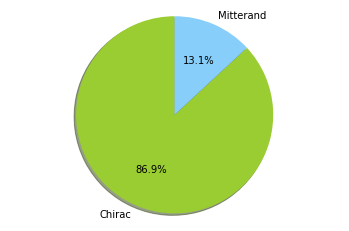

In [21]:
labels =  'Chirac','Mitterand'
alllabs2 = np.array(alllabs)

sizes = [len(alllabs2[alllabs2 == 1]), len(alllabs2[alllabs2 == -1])]
colors = ["yellowgreen", "lightskyblue"]

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')

plt.savefig('PieChart01.png')
plt.show()

#### Les 100 mots les plus fréquents avant pre-process

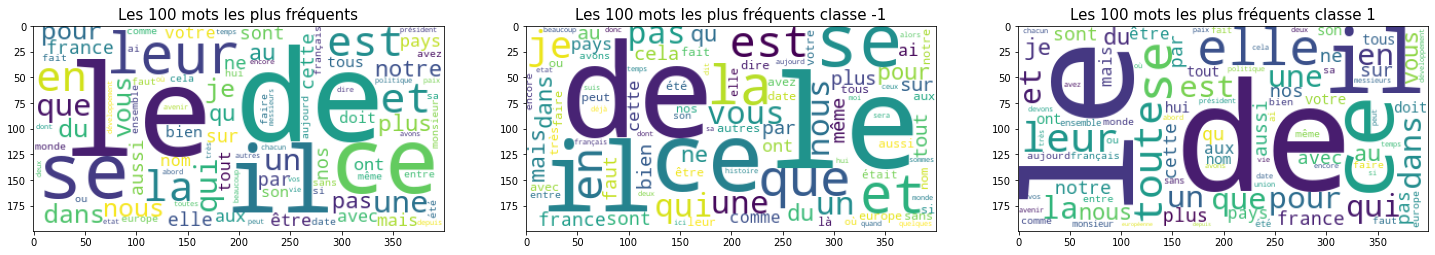

In [4]:
ind = 0
n_model = 3
n = 100
vectorizer = [TfidfVectorizer(),TfidfVectorizer(),TfidfVectorizer()]
data = [alltxts,np.array(alltxts)[np.where(np.array(alllabs) == -1)],np.array(alltxts)[np.where(np.array(alllabs) == 1)]]
title = ["Les 100 mots les plus fréquents","Les 100 mots les plus fréquents classe -1","Les 100 mots les plus fréquents classe 1"]

plt.figure(figsize=(25,25))
for i in range(n_model):
    ind += 1
    plt.subplot(1,n_model,ind)
    affiche_word_cloud_top_100(vectorizer[i],data[i],title[i],n=n)

#### Les 100 mots les plus fréquents apres pre-process

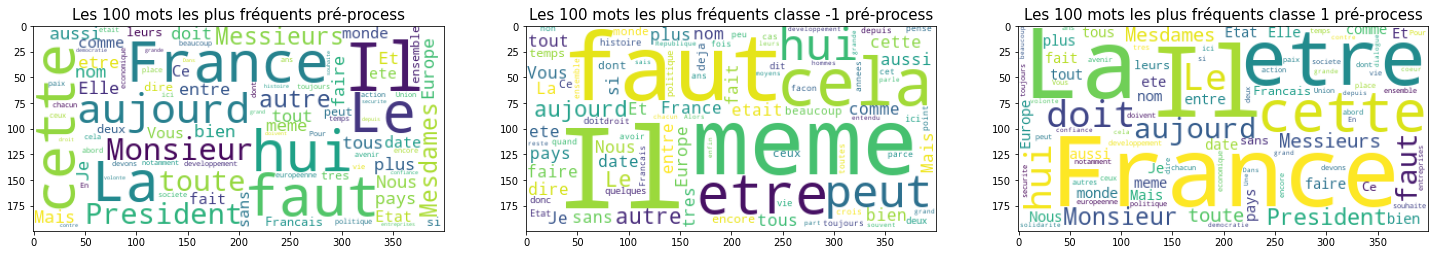

In [5]:
ind = 0
n_model = 3
n = 100
vectorizer1 = TfidfVectorizer(lowercase=False,       # Almost false everytime in our case
                                 stop_words=stopwords.words('french'),       # Never remove stopwords
                                 strip_accents="ascii", # Sometimes none sometimes ascii, doesn't really matter
                                 use_idf=True,          # Always true
                                 smooth_idf=False,      # Sometimes true sometimes false, doesn't really matter
                                 sublinear_tf=True,     # Sometimes true sometimes false, doesn't really matter
                             
                                 max_features=50_000,   # Avoids overfit and reduce noise
                                 min_df=1,              # Always 1, meaning we don't remove anything
                                 max_df=0.79,           # One of the most meaningful parameters, can be 0.05, 0.9 ...
                                 ngram_range=(1,2),     # Always unigram + bigram
                                 )
vectorizer2 = TfidfVectorizer(lowercase=False,       # Almost false everytime in our case
                                 stop_words=stopwords.words('french'),       # Never remove stopwords
                                 strip_accents="ascii", # Sometimes none sometimes ascii, doesn't really matter
                                 use_idf=True,          # Always true
                                 smooth_idf=False,      # Sometimes true sometimes false, doesn't really matter
                                 sublinear_tf=True,     # Sometimes true sometimes false, doesn't really matter
                             
                                 max_features=50_000,   # Avoids overfit and reduce noise
                                 min_df=1,              # Always 1, meaning we don't remove anything
                                 max_df=0.79,           # One of the most meaningful parameters, can be 0.05, 0.9 ...
                                 ngram_range=(1,2),     # Always unigram + bigram
                                 )
vectorizer3 = TfidfVectorizer(lowercase=False,       # Almost false everytime in our case
                                 stop_words=stopwords.words('french'),       # Never remove stopwords
                                 strip_accents="ascii", # Sometimes none sometimes ascii, doesn't really matter
                                 use_idf=True,          # Always true
                                 smooth_idf=False,      # Sometimes true sometimes false, doesn't really matter
                                 sublinear_tf=True,     # Sometimes true sometimes false, doesn't really matter
                             
                                 max_features=50_000,   # Avoids overfit and reduce noise
                                 min_df=1,              # Always 1, meaning we don't remove anything
                                 max_df=0.79,           # One of the most meaningful parameters, can be 0.05, 0.9 ...
                                 ngram_range=(1,2),     # Always unigram + bigram
                                 )

vectorizer = [vectorizer1,vectorizer2,vectorizer3]
data = [alltxts,np.array(alltxts)[np.where(np.array(alllabs) == -1)],np.array(alltxts)[np.where(np.array(alllabs) == 1)]]
title = ["Les 100 mots les plus fréquents pré-process","Les 100 mots les plus fréquents classe -1 pré-process","Les 100 mots les plus fréquents classe 1 pré-process"]

plt.figure(figsize=(25,25))
for i in range(n_model):
    ind += 1
    plt.subplot(1,n_model,ind)
    affiche_word_cloud_top_100(vectorizer[i],data[i],title[i],n=n)

#### Les 100 mots odd ratio avant pre-process

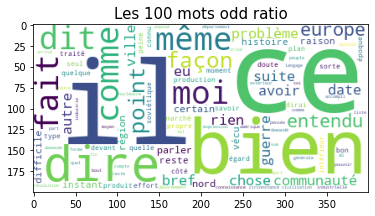

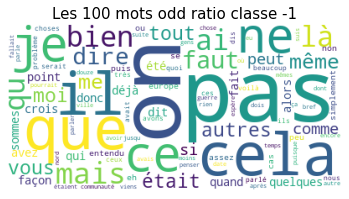

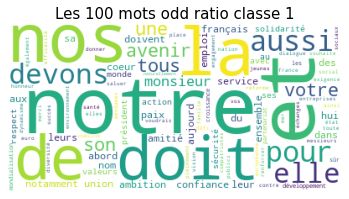

In [6]:

vectorizer = [TfidfVectorizer(),TfidfVectorizer(),TfidfVectorizer()]
data = [alltxts,np.array(alltxts)[np.where(np.array(alllabs) == -1)],np.array(alltxts)[np.where(np.array(alllabs) == 1)]]
title = ["Les 100 mots odd ratio","Les 100 mots odd ratio classe -1","Les 100 mots odd ratio classe 1"]
  
affichage_odd_ratio(vectorizer,data,title,n=100)

#### Les 100 mots odd ratio apres pre-process

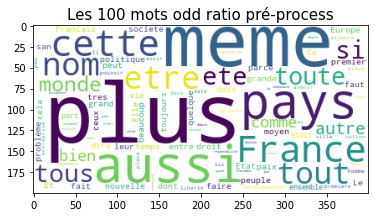

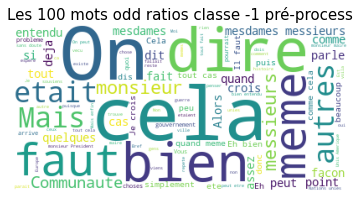

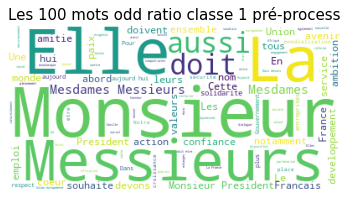

In [7]:
ind = 0
n_model = 3
n = 100
vectorizer1 = TfidfVectorizer(lowercase=False,       # Almost false everytime in our case
                                 stop_words=stopwords.words('french'),       # Never remove stopwords
                                 strip_accents="ascii", # Sometimes none sometimes ascii, doesn't really matter
                                 use_idf=True,          # Always true
                                 smooth_idf=False,      # Sometimes true sometimes false, doesn't really matter
                                 sublinear_tf=True,     # Sometimes true sometimes false, doesn't really matter
                             
                                 max_features=50_000,   # Avoids overfit and reduce noise
                                 min_df=1,              # Always 1, meaning we don't remove anything
                                 max_df=0.79,           # One of the most meaningful parameters, can be 0.05, 0.9 ...
                                 ngram_range=(1,2),     # Always unigram + bigram
                                 )
vectorizer2 = TfidfVectorizer(lowercase=False,       # Almost false everytime in our case
                                 stop_words=stopwords.words('french'),       # Never remove stopwords
                                 strip_accents="ascii", # Sometimes none sometimes ascii, doesn't really matter
                                 use_idf=True,          # Always true
                                 smooth_idf=False,      # Sometimes true sometimes false, doesn't really matter
                                 sublinear_tf=True,     # Sometimes true sometimes false, doesn't really matter
                             
                                 max_features=50_000,   # Avoids overfit and reduce noise
                                 min_df=1,              # Always 1, meaning we don't remove anything
                                 max_df=0.79,           # One of the most meaningful parameters, can be 0.05, 0.9 ...
                                 ngram_range=(1,2),     # Always unigram + bigram
                                 )
vectorizer3 = TfidfVectorizer(lowercase=False,       # Almost false everytime in our case
                                 stop_words=stopwords.words('french'),       # Never remove stopwords
                                 strip_accents="ascii", # Sometimes none sometimes ascii, doesn't really matter
                                 use_idf=True,          # Always true
                                 smooth_idf=False,      # Sometimes true sometimes false, doesn't really matter
                                 sublinear_tf=True,     # Sometimes true sometimes false, doesn't really matter
                             
                                 max_features=50_000,   # Avoids overfit and reduce noise
                                 min_df=1,              # Always 1, meaning we don't remove anything
                                 max_df=0.79,           # One of the most meaningful parameters, can be 0.05, 0.9 ...
                                 ngram_range=(1,2),     # Always unigram + bigram
                                 )

vectorizer = [vectorizer1,vectorizer2,vectorizer3]
data = [alltxts,np.array(alltxts)[np.where(np.array(alllabs) == -1)],np.array(alltxts)[np.where(np.array(alllabs) == 1)]]
title = ["Les 100 mots odd ratio pré-process","Les 100 mots odd ratios classe -1 pré-process","Les 100 mots odd ratio classe 1 pré-process"]

affichage_odd_ratio(vectorizer,data,title,n=100)

#### Distribution zipf

[ 0.69314718  0.69314718  0.69314718 ... 10.45478311 10.58898051
 11.13575623]
['ôté' 'négocient' 'négocions' ... 'et' 'la' 'de']


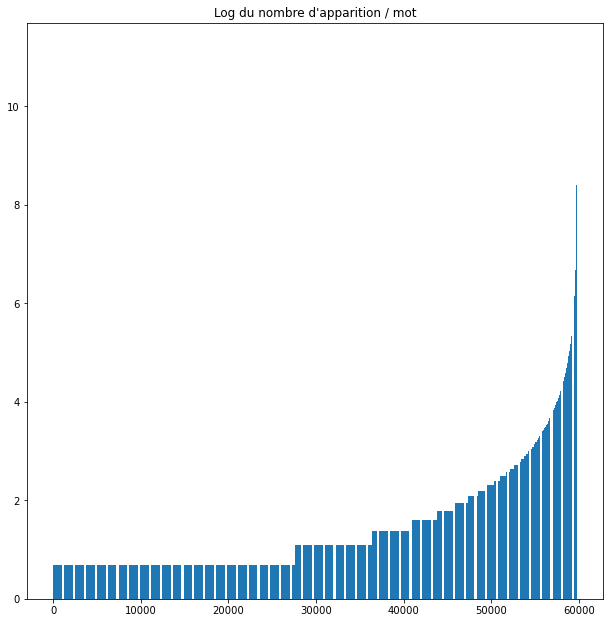

In [8]:
affiche_zipf(alltxts)

# Film

In [15]:

fname = "./AFDmovies/movies1000/"
alltxts,alllabs = load_movies(fname)

# Changement de label de 0 en -1
alllabs = np.array(alllabs)
alllabs[np.where( alllabs == 0)[0]] = -1

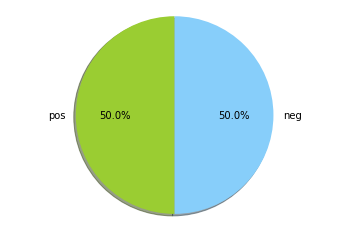

In [16]:
labels =  'pos','neg'
alllabs2 = np.array(alllabs)

sizes = [len(alllabs2[alllabs2 == 1]), len(alllabs2[alllabs2 == -1])]
colors = ["yellowgreen", "lightskyblue"]

plt.pie(sizes, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')

plt.savefig('PieChart01.png')
plt.show()

#### Les 100 mots les plus fréquents avant pre-process

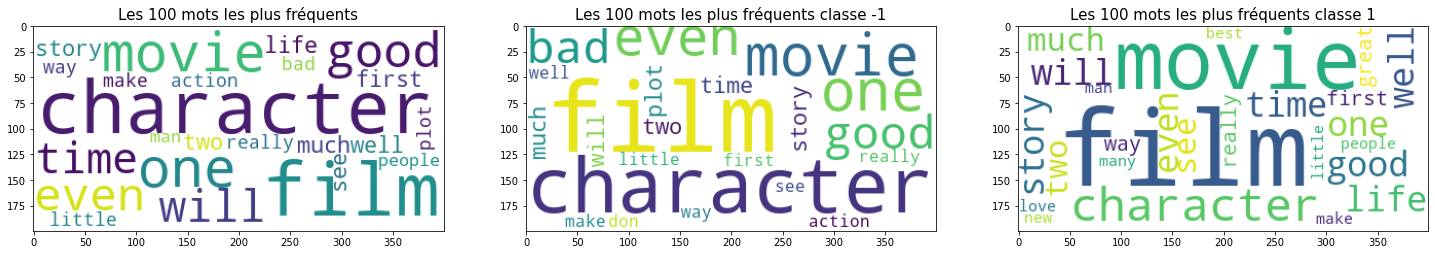

In [10]:
ind = 0
n_model = 3
n = 100
vectorizer = [TfidfVectorizer(),TfidfVectorizer(),TfidfVectorizer()]
data = [alltxts,np.array(alltxts)[np.where(np.array(alllabs) == -1)],np.array(alltxts)[np.where(np.array(alllabs) == 1)]]
title = ["Les 100 mots les plus fréquents","Les 100 mots les plus fréquents classe -1","Les 100 mots les plus fréquents classe 1"]

plt.figure(figsize=(25,25))
for i in range(n_model):
    ind += 1
    plt.subplot(1,n_model,ind)
    affiche_word_cloud_top_100(vectorizer[i],data[i],title[i],n=n)

#### Les 100 mots odd ratio apres  pre-process

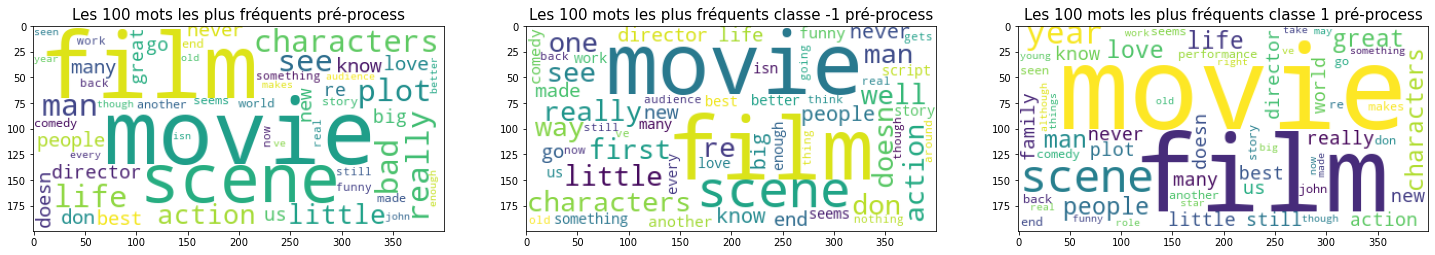

In [11]:
ind = 0
n_model = 3
n = 100
vectorizer1 = TfidfVectorizer(lowercase=False,
                                     stop_words=None,
                                     strip_accents=None,
                                     # use_idf=True,
                                     # smooth_idf=True,
                                     # sublinear_tf=False,

                                     max_features=10_000,
                                     min_df=5,
                                     max_df=0.5,
                                     ngram_range=(1,2),
                                     )

vectorizer2 = TfidfVectorizer(lowercase=False,
                                     stop_words=None,
                                     strip_accents=None,
                                     # use_idf=True,
                                     # smooth_idf=True,
                                     # sublinear_tf=False,

                                     max_features=10_000,
                                     min_df=5,
                                     max_df=0.5,
                                     ngram_range=(1,2),
                                     )

vectorizer3 = TfidfVectorizer(lowercase=False,
                                     stop_words=None,
                                     strip_accents=None,
                                     # use_idf=True,
                                     # smooth_idf=True,
                                     # sublinear_tf=False,

                                     max_features=10_000,
                                     min_df=5,
                                     max_df=0.5,
                                     ngram_range=(1,2),
                                     )

vectorizer = [vectorizer1,vectorizer2,vectorizer3]
data = [alltxts,np.array(alltxts)[np.where(np.array(alllabs) == -1)],np.array(alltxts)[np.where(np.array(alllabs) == 1)]]
title = ["Les 100 mots les plus fréquents pré-process","Les 100 mots les plus fréquents classe -1 pré-process","Les 100 mots les plus fréquents classe 1 pré-process"]

plt.figure(figsize=(25,25))
for i in range(n_model):
    ind += 1
    plt.subplot(1,n_model,ind)
    affiche_word_cloud_top_100(vectorizer[i],data[i],title[i],n=n)

#### Les 100 mots odd ratio avant pre-process

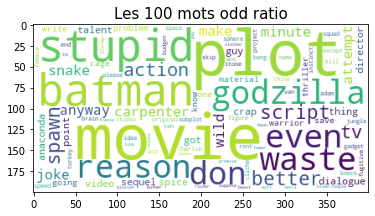

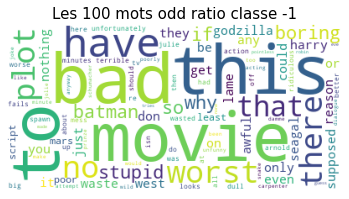

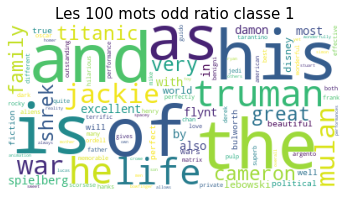

In [12]:

vectorizer = [TfidfVectorizer(),TfidfVectorizer(),TfidfVectorizer()]
data = [alltxts,np.array(alltxts)[np.where(np.array(alllabs) == -1)],np.array(alltxts)[np.where(np.array(alllabs) == 1)]]
title = ["Les 100 mots odd ratio","Les 100 mots odd ratio classe -1","Les 100 mots odd ratio classe 1"]
  
affichage_odd_ratio(vectorizer,data,title,n=100)

#### Les 100 mots odd ratio apres pre-process

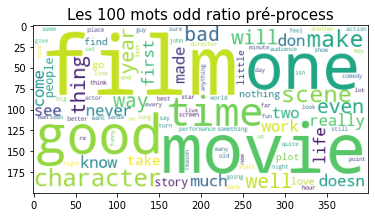

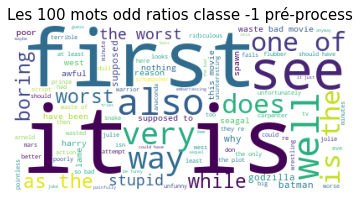

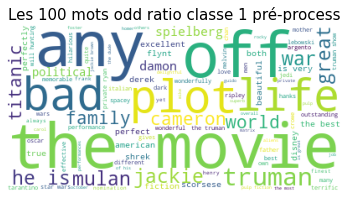

In [13]:
ind = 0
n_model = 3
n = 100

vectorizer1 = TfidfVectorizer(lowercase=False,
                                     stop_words=None,
                                     strip_accents=None,
                                     # use_idf=True,
                                     # smooth_idf=True,
                                     # sublinear_tf=False,

                                     max_features=10_000,
                                     min_df=5,
                                     max_df=0.5,
                                     ngram_range=(1,2),
                                     )

vectorizer2 = TfidfVectorizer(lowercase=False,
                                     stop_words=None,
                                     strip_accents=None,
                                     # use_idf=True,
                                     # smooth_idf=True,
                                     # sublinear_tf=False,

                                     max_features=10_000,
                                     min_df=5,
                                     max_df=0.5,
                                     ngram_range=(1,2),
                                     )

vectorizer3 = TfidfVectorizer(lowercase=False,
                                     stop_words=None,
                                     strip_accents=None,
                                     # use_idf=True,
                                     # smooth_idf=True,
                                     # sublinear_tf=False,

                                     max_features=10_000,
                                     min_df=5,
                                     max_df=0.5,
                                     ngram_range=(1,2),
                                     )

vectorizer = [vectorizer1,vectorizer2,vectorizer3]
data = [alltxts,np.array(alltxts)[np.where(np.array(alllabs) == -1)],np.array(alltxts)[np.where(np.array(alllabs) == 1)]]
title = ["Les 100 mots odd ratio pré-process","Les 100 mots odd ratios classe -1 pré-process","Les 100 mots odd ratio classe 1 pré-process"]

affichage_odd_ratio(vectorizer,data,title,n=100)

#### Distribution zipf

[ 0.69314718  0.69314718  0.69314718 ... 11.09554465 11.24084111
 11.26084217]
['\x05' 'magali' "mafia's" ... '.' 'the' ',']


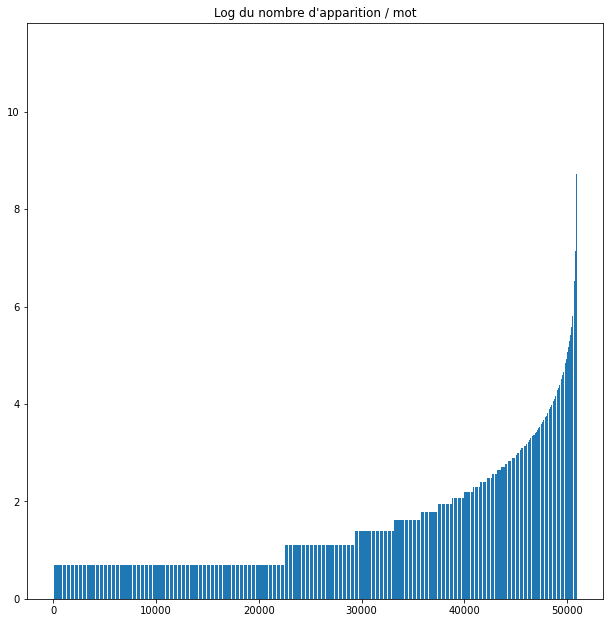

In [14]:
affiche_zipf(alltxts)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,classification_report,roc_auc_score

fname = "./AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts,alllabs = load_pres(fname)

vectorizer = TfidfVectorizer()
clf = LinearSVC(class_weight="balanced",
                      max_iter=10_000,
                C=1.15)

X_train,X_test,y_train,y_test = train_test_split(alltxts,alllabs,test_size=0.33,random_state=1)
    
dico_param = {
#     "lowercase":False,
#      "stop_words":None,
#      "strip_accents":None,
#       #"use_idf":True,
#       #"smooth_idf":False,
#      #"sublinear_tf":True,
#      "max_features":50_000,
#      "min_df":1,
#      "max_df":0.5,
#      "ngram_range":(1,2)
    } #Param's optimal

liste_x = np.arange(1,32,2) #min_df
liste_y = np.linspace(0.01,1,16) #max_df
# liste_z = [(1,1),(1,2),(2,2)] #n_gram

display_graphic_analysis(dico_param,liste_x,liste_y,liste_z,clf,X_train,X_test,y_train,y_test,"president")